In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

In [2]:
os.getcwd()

'/Users/sharduljanaskar'

In [3]:
os.chdir("/Users/sharduljanaskar/Documents")

In [4]:
df = pd.read_csv("reviews.csv")

In [5]:
df = df.rename(columns = {'date' : 'ds', 'listing_id' : 'ts'})

In [6]:
df_example = df.groupby(by = 'ds').agg({'ts' : 'count'})

In [7]:
df_example.index = pd.to_datetime(df_example.index)

In [8]:
df_example = df_example.asfreq(freq='1D')

In [9]:
df_example = df_example.sort_index(ascending = True)

In [10]:
df_example = df_example.fillna(value = 0)

/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


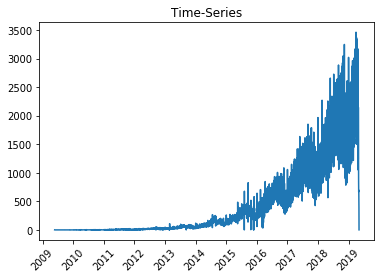

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])
ax.set_title('Time-Series')
ax.tick_params(axis = 'x', rotation = 45)
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df,ts):
    rolmean = df[ts].rolling(window = 12,center=False).mean()
    rolstd = df[ts].rolling(window=12,center=False).std()
    
    orig = plt.plot(df[ts],color = 'blue', label = "Original")
    mean = plt.plot(rolmean,color = 'red', label = "RollingMean")
    std = plt.plot(rolstd, color = 'black', label = 'Std')
    plt.legend(loc = 'best')
    plt.title("Timeseries")
    plt.xticks(rotation = 45)
    plt.show()
    plt.close()
    
    print("results of ad-fuller:")
    dftest = adfuller(df[ts],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index = ["Test-statistics","p-value","# lags used",'# observations used'])
    
    for key,value in dftest[4].items():
        dfoutput["Critical value (%s)" %key] = value
    print(dfoutput)

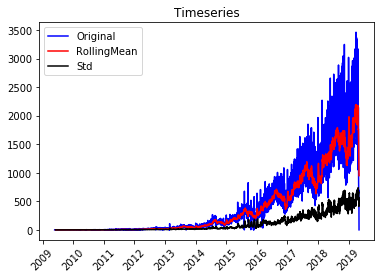

results of ad-fuller:
Test-statistics           -1.960060
p-value                    0.304355
# lags used               30.000000
# observations used     3602.000000
Critical value (1%)       -3.432167
Critical value (5%)       -2.862343
Critical value (10%)      -2.567197
dtype: float64


In [13]:
test_stationarity(df = df_example, ts = 'ts')

In [14]:
def plot_transformed_ts(df,ts, transformed_ts):
    
    fig,ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[transformed_ts], color = "red")
    ax.set_title("%s and %s time-series plot" %(ts, transformed_ts))
    ax.tick_params(axis='x', rotation = 45)
    ax.legend([ts,transformed_ts])
    plt.show()
    plt.close()
    return

In [15]:
# Transformation of ts using log
df_example['ts_log'] = df_example['ts'].apply( lambda x: np.log(x))
# Transformation - 7 day moving_avg of ts_log
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,center =False).mean()
# Transformation - 7 day moving_avg of ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7, center =False).mean()
# Transformation - difference of ts_log and first-order differenced logged ts
df_example['ts_log_diff'] = df_example['ts_log'].diff()
#Transformation - difference between ts and moving_avg ts
df_example['ts_moving_avg_diff'] = df_example['ts']-df_example['ts_moving_avg']
#Transformation - difference between ts_log and ts_log_moving_avg 
df_example['ts_log_moving_avg_diff'] = df_example['ts_log']-df_example['ts_log_moving_avg']
#Transformation - dropping the nan values
df_example_transformed = df_example.dropna()
#Transformation - taking the exponentialy weighted moving avg of ts_log, halflife = 7days
df_example_transformed['ts_log_ewma'] = df_example_transformed['ts_log'].ewm(halflife = 7,
                                                                            ignore_na = False,
                                                                            min_periods = 0, 
                                                                            adjust=True).mean()
#Transformation - difference between ts_log and ts_log_ewma
df_example_transformed['ts_log_ewma_diff'] = df_example_transformed['ts_log'] - df_example_transformed['ts_log_ewma']


/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/pandas/core/algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
df_example_transformed.head()

,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-07-04,1.0,0.000000,0.198042,1.285714,-0.693147,-0.285714,-0.198042,0.000000,0.000000
2010-07-05,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-06,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-16,2.0,0.693147,0.594126,1.857143,0.000000,0.142857,0.099021,0.199809,0.493339
2010-07-28,1.0,0.000000,0.255966,1.428571,0.000000,-0.428571,-0.255966,0.151569,-0.151569


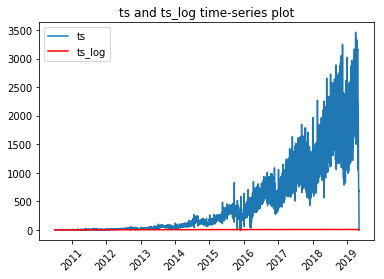

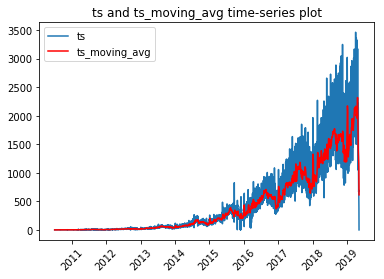

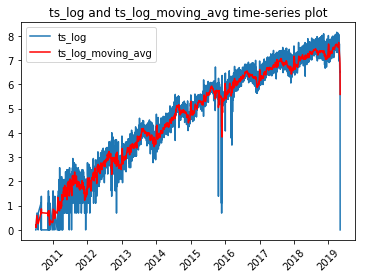

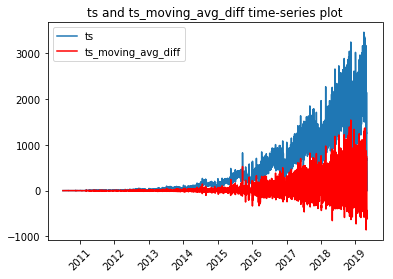

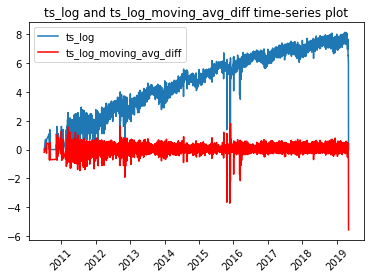

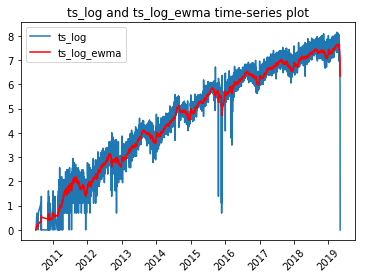

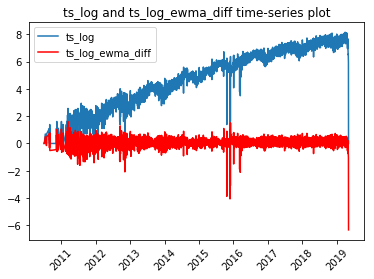

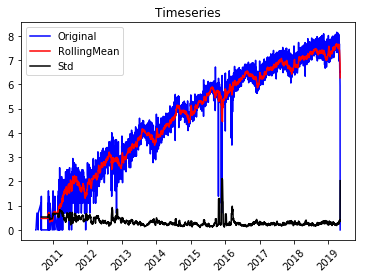

results of ad-fuller:
Test-statistics           -2.586840
p-value                    0.095748
# lags used               27.000000
# observations used     2923.000000
Critical value (1%)       -3.432589
Critical value (5%)       -2.862529
Critical value (10%)      -2.567297
dtype: float64


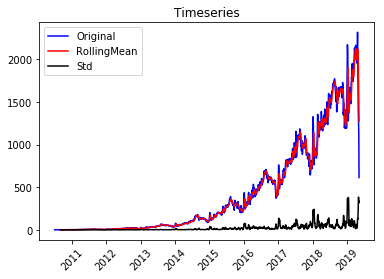

results of ad-fuller:
Test-statistics           -1.408211
p-value                    0.578334
# lags used               28.000000
# observations used     2922.000000
Critical value (1%)       -3.432590
Critical value (5%)       -2.862530
Critical value (10%)      -2.567297
dtype: float64


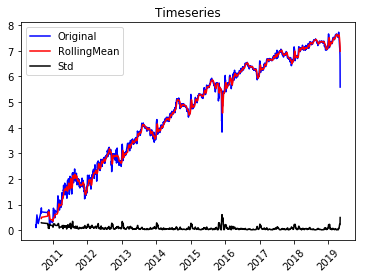

results of ad-fuller:
Test-statistics           -2.415136
p-value                    0.137510
# lags used               24.000000
# observations used     2926.000000
Critical value (1%)       -3.432587
Critical value (5%)       -2.862528
Critical value (10%)      -2.567296
dtype: float64


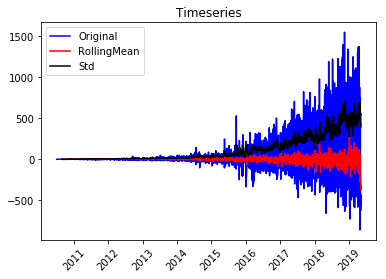

results of ad-fuller:
Test-statistics        -6.424311e+00
p-value                 1.759959e-08
# lags used             2.800000e+01
# observations used     2.922000e+03
Critical value (1%)    -3.432590e+00
Critical value (5%)    -2.862530e+00
Critical value (10%)   -2.567297e+00
dtype: float64


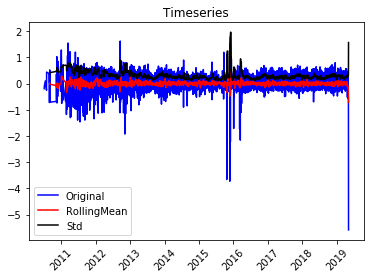

results of ad-fuller:
Test-statistics        -9.289123e+00
p-value                 1.192951e-15
# lags used             2.700000e+01
# observations used     2.923000e+03
Critical value (1%)    -3.432589e+00
Critical value (5%)    -2.862529e+00
Critical value (10%)   -2.567297e+00
dtype: float64


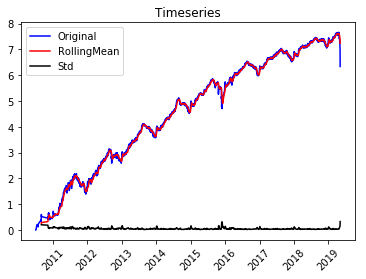

results of ad-fuller:
Test-statistics           -2.593711
p-value                    0.094304
# lags used               28.000000
# observations used     2922.000000
Critical value (1%)       -3.432590
Critical value (5%)       -2.862530
Critical value (10%)      -2.567297
dtype: float64


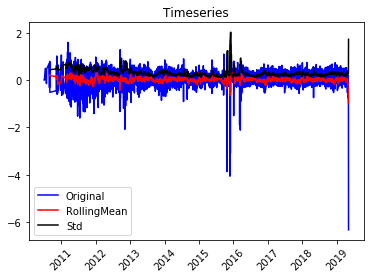

results of ad-fuller:
Test-statistics        -7.087040e+00
p-value                 4.510367e-10
# lags used             2.700000e+01
# observations used     2.923000e+03
Critical value (1%)    -3.432589e+00
Critical value (5%)    -2.862529e+00
Critical value (10%)   -2.567297e+00
dtype: float64


In [17]:
#Plot data
plot_transformed_ts(df = df_example_transformed,ts = 'ts', transformed_ts='ts_log')
plot_transformed_ts(df = df_example_transformed,ts = 'ts', transformed_ts='ts_moving_avg')
plot_transformed_ts(df = df_example_transformed,ts = 'ts_log', transformed_ts='ts_log_moving_avg')
plot_transformed_ts(df = df_example_transformed,ts = 'ts', transformed_ts='ts_moving_avg_diff')
plot_transformed_ts(df = df_example_transformed,ts = 'ts_log', transformed_ts='ts_log_moving_avg_diff')
plot_transformed_ts(df = df_example_transformed,ts = 'ts_log', transformed_ts='ts_log_ewma')
plot_transformed_ts(df = df_example_transformed,ts = 'ts_log', transformed_ts='ts_log_ewma_diff')

#Check for stationarity
test_stationarity(df = df_example_transformed, ts = 'ts_log')
test_stationarity(df = df_example_transformed, ts = 'ts_moving_avg')
test_stationarity(df = df_example_transformed, ts = 'ts_log_moving_avg')
test_stationarity(df = df_example_transformed, ts = 'ts_moving_avg_diff')
test_stationarity(df = df_example_transformed, ts = 'ts_log_moving_avg_diff')
test_stationarity(df = df_example_transformed, ts = 'ts_log_ewma')
test_stationarity(df = df_example_transformed, ts = 'ts_log_ewma_diff')


In [18]:
def plot_decompose(df, ts, trend, seasonality,residual):
    f , ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (15,5),sharex = True)
    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis= 'x', rotation = 45)
    
    ax2.plot(df[trend], label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis= 'x', rotation = 45)
    
    ax3.plot(df[seasonality], label = 'Seasonal')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis= 'x', rotation = 45)
    
    ax4.plot(df[residual], label = 'Residual')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis= 'x', rotation = 45)
    
    plt.suptitle("Trend, Seasonality and Residuls of %s" %(ts),
                x = 0.5,
                y = 1.05,
                fontsize = 18)
    plt.show()
    plt.close()
    
    return

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df_example_transformed['ts_log'], freq = 365)

In [20]:
df_example_transformed.loc[:,'trend'] = decompose.trend
df_example_transformed.loc[:,'seasonality'] = decompose.seasonal
df_example_transformed.loc[:,'residual'] = decompose.resid

/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


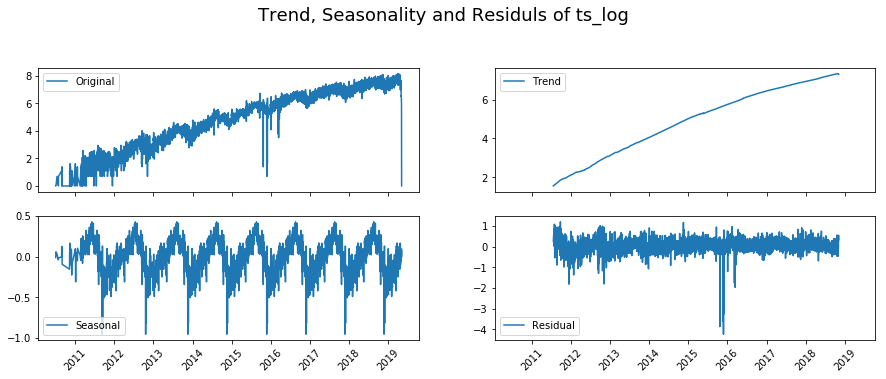

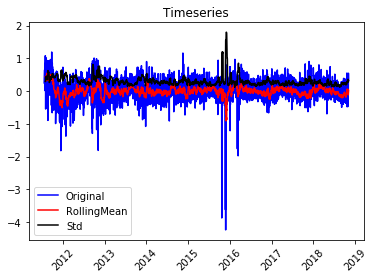

results of ad-fuller:
Test-statistics        -7.137222e+00
p-value                 3.396319e-10
# lags used             2.700000e+01
# observations used     2.559000e+03
Critical value (1%)    -3.432908e+00
Critical value (5%)    -2.862670e+00
Critical value (10%)   -2.567372e+00
dtype: float64


In [21]:
plot_decompose(df = df_example_transformed, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonality = 'seasonality', 
                   residual = 'residual')
test_stationarity(df = df_example_transformed.dropna(), ts = 'residual')

In [22]:
def plot_acf_pacf(df, ts):
    f, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
    
    ax1.plot(lag_acf)
    ax1.axhline(y = 0, linestyle='--',color='gray')
    ax1.axhline(y = -1.96/np.sqrt(len(df[ts])), linestyle='--',color='gray')
    ax1.axhline(y = 1.96/np.sqrt(len(df[ts])), linestyle='--',color='gray')
    ax1.set_title('Autocorrelation Function for %s' %(ts))
    
    ax2.plot(lag_acf)
    ax2.axhline(y = 0, linestyle='--',color='gray')
    ax2.axhline(y = -1.96/np.sqrt(len(df[ts])), linestyle='--',color='gray')
    ax2.axhline(y = 1.96/np.sqrt(len(df[ts])), linestyle='--',color='gray')
    ax2.set_title('Autocorrelation Function for %s' %(ts))
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return

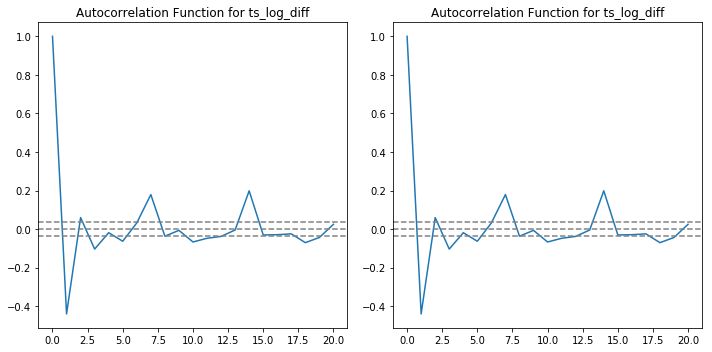

In [23]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(np.array(df_example_transformed['ts_log_diff']), nlags=20)
lag_pacf = pacf(np.array(df_example_transformed['ts_log_diff']), nlags=20)

plot_acf_pacf(df = df_example_transformed, ts = 'ts_log_diff')

In [24]:
from statsmodels.tsa.arima_model import ARIMA

def run_arima_model(df,ts,p,d,q):
    
    model = ARIMA(df[ts], order=(p, d, q))  
    results_ = model.fit(disp=-1)  
    len_results = len(results_.fittedvalues)
    ts_modified = df[ts][-len_results:]
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df[ts]))
    plt.plot(df[ts])
    plt.plot(results_.fittedvalues, color = 'red')
    plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))

    plt.show()
    plt.close()

    return results_

/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


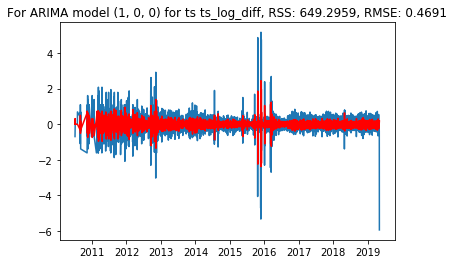

/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


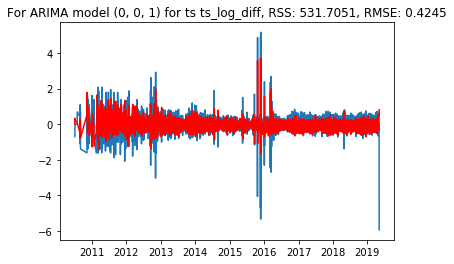

/Users/sharduljanaskar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


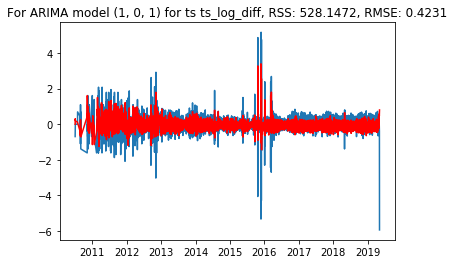

In [25]:
model_AR = run_arima_model(df = df_example_transformed, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

model_MA = run_arima_model(df = df_example_transformed, 
                           ts = 'ts_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

model_MA = run_arima_model(df = df_example_transformed, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)

In [26]:
df_ = df_example_transformed[['ts']]
df_ = df_.reset_index()
df_ = df_.rename(columns = {'ds': 'ds', 'ts': 'y'})
df_['ds'] = pd.to_datetime(df_['ds'])
df_['y'] = pd.to_numeric(df_['y'], errors='ignore')

In [70]:
def do_lstm_moel(df,ts,look_back,epochs,type_=None,train_fraction = 0.67):
    
    import numpy as np
    import pandas
    import math
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error
    
    def create_df(dataset,look_back = 1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back),0]
            dataX.append(a)
            dataY.append(dataset[i+look_back,0])
        return np.array(dataX),np.array(dataY)
    
    np.random.seed(42)
    dataset = df[ts].values
    dataset = dataset.astype('float32')
    
    scalar = MinMaxScaler(feature_range=(0,1))
    dataset = scalar.fit_transform(dataset.reshape(-1,1))
    
    train_size = int(len(dataset)*train_fraction)
    test_size = len(dataset)-train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    look_back = look_back
    train_X, train_y = create_df(train,look_back)
    test_X, test_y = create_df(test,look_back)
    
    
    if type_ == 'regression with time steps':
        train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
        test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
    elif type_ == 'stacked with memory between batches':
        train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
        test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
    else:
        train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
        test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
    
    batch_size = 1
    model = Sequential()
    
    if type_ == 'regression with time steps':
        model.add(LSTM(4,input_shape = (look_back,1)))
    elif type_ == 'memory between batches':
        model.add(LSTM(4,batch_input_shape=(batch_size,look_back,1), stateful = True))
    elif type_ == 'stacked with memory between batches':
        model.add(LSTM(4,batch_input_shape=(batch_size,look_back,1), stateful = True,return_sequences = True))
        model.add(LSTM(4,batch_input_shape=(batch_size,look_back,1), stateful = True))
    else:
        model.add(LSTM(4,input_shape=(1,look_back)))
        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
        for i in range(100):
            model.fit(train_X,train_y,epochs=1,batch_size=batch_size,verbose = 2,shuffle=False)
            model.reset_states()
    else:
        model.fit(train_X,train_y,epochs = epochs,batch_size=1,verbose=2)
        
        
    if type_ == 'memory between batches' or type_ == 'stacked with memory between batches':
        train_predict = model.predict(train_X,batch_size=batch_size)
        test_predict = model.predict(test_X,batch_size=batch_size)
    else:
        train_predict = model.predict(train_X)
        test_predict = model.predict(test_X)
        
    train_predict = scalar.inverse_transform(train_predict)
    train_y = scalar.inverse_transform([train_y])
    test_predict = scalar.inverse_transform(test_predict)
    test_y = scalar.inverse_transform([test_y])
    
    trainScore = math.sqrt(mean_squared_error(train_y[0],train_predict[:,0]))
    print("TrainScore : %.2f RMSE" %(trainScore))
    testScore = math.sqrt(mean_squared_error(test_y[0],test_predict[:,0]))
    print("TestScore : %.2f RMSE" %(testScore))
    
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict
    
    plt.plot(scalar.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    plt.close()
    
    
    return

Epoch 1/5
 - 8s - loss: 0.0012
Epoch 2/5
 - 6s - loss: 4.4279e-04
Epoch 3/5
 - 6s - loss: 4.3313e-04
Epoch 4/5
 - 6s - loss: 4.3305e-04
Epoch 5/5
 - 6s - loss: 4.3267e-04
TrainScore : 70.33 RMSE
TestScore : 409.52 RMSE


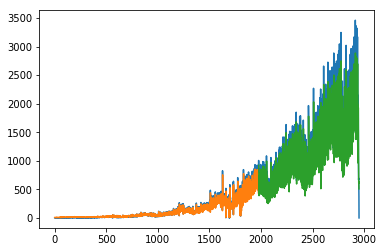

Epoch 1/5
 - 7s - loss: 5.7307e-04
Epoch 2/5
 - 5s - loss: 4.0438e-04
Epoch 3/5
 - 5s - loss: 3.9486e-04
Epoch 4/5
 - 5s - loss: 3.8759e-04
Epoch 5/5
 - 5s - loss: 3.8267e-04
TrainScore : 66.54 RMSE
TestScore : 430.60 RMSE


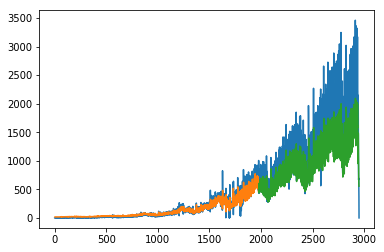

Epoch 1/5
 - 11s - loss: 7.6478e-04
Epoch 2/5
 - 9s - loss: 4.3163e-04
Epoch 3/5
 - 8s - loss: 4.1728e-04
Epoch 4/5
 - 8s - loss: 4.0645e-04
Epoch 5/5
 - 8s - loss: 4.0319e-04
TrainScore : 67.85 RMSE
TestScore : 436.30 RMSE


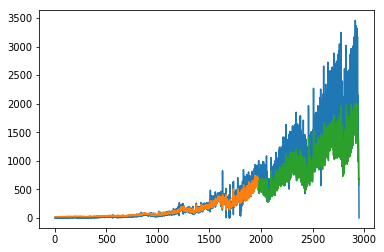

In [71]:
do_lstm_moel(df = df_,
            ts = 'y',
            look_back = 1,
            epochs = 5)

do_lstm_moel(df = df_,
            ts = 'y',
            look_back = 3,
            epochs = 5)

do_lstm_moel(df = df_,
            ts = 'y',
            look_back = 3,
            epochs = 5,
            type_ = "regression with time steps")

# do_lstm_moel(df = df_,
#             ts = 'y',
#             look_back = 3,
#             epochs = 5,
#             type_ = 'memory between batches')

# do_lstm_moel(df = df_,
#             ts = 'y',
#             look_back = 3,
#             epochs = 5,
#             type_ = 'stacked with memory between batches')